In [292]:
%load_ext autoreload
%autoreload 2
#required packages
import os
import glob
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from scipy import signal, stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from tqdm import tqdm
#my funcs
from ecog_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [293]:
#outlier rejection function
def reject_outliers(data, thr = 1.5, twosided = True):
    clean = []
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3-q1
    outlier_n = 0
    for point in data:
        if twosided:
            if point <= q3 + thr*iqr and point >= q1 - thr*iqr:
                clean.append(point)
            else:
                outlier_n +=1
        else:
            if point <= q3 + thr*iqr:
                clean.append(point)
            else:
                outlier_n += 1
    if outlier_n >0:
        print(f'found {outlier_n} outliers')
    
    return clean

In [294]:
#random funcs
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

In [295]:
DATA_SUFFIX = 'spectral_final'
DATA_DIR = 'C:/Users/marty/Projects/sleep_new/res_temp/*.pkl'

In [296]:
DIR = glob.glob(DATA_DIR)
STATE_PATHS = [PATH for PATH in DIR if DATA_SUFFIX in PATH and 'state' in PATH]
TIME_PATHS = [PATH for PATH in DIR if DATA_SUFFIX in PATH and 'time' in PATH]

In [297]:
#load data
state_data = []
for path in tqdm(STATE_PATHS):
    state_data.append(pickle.load(open(path, 'rb')))
state_data = pd.concat(state_data).reset_index(drop=True)

100%|██████████| 6810/6810 [00:02<00:00, 3301.73it/s]


In [298]:
time_data = []
for path in tqdm(TIME_PATHS):
    time_data.append(pickle.load(open(path, 'rb')))
time_data = pd.concat(time_data).reset_index(drop=True)

100%|██████████| 6810/6810 [00:00<00:00, 7135.89it/s]


In [299]:
len(state_data['id'].unique())

29

In [300]:
len(time_data['id'].unique())

29

In [301]:
#things to set groups/injs
#assign groups - if rat is not here, then in  sal
w_cbn_ids = [5,7,7,12,14,16] 
w_sal_ids = [6,8,10,11,13,15]
cbn_ids = [23,24,31,35,42,46,52]
veh_ids = [21,26,33,34,43,45,55]

In [302]:
#mark days where single injections occured, format YYYY-MM-DD (same as index col)
single_inj_dates=pd.to_datetime(['2023-11-18 08:30','2024-01-03 08:30','2023-04-05 08:30','2023-06-07 08:30', '2024-03-04 08:30', '2024-03-21'])

In [303]:
#set cont inj
cont_inj_day1 = pd.to_datetime(['2023-04-09 08:30','2023-05-29 08:30','2023-11-08 08:30','2024-01-08 08:30','2024-02-24 08:30','2024-03-24 08:30'])
cont_inj_day2 = pd.to_datetime(['2023-04-10 08:30','2023-05-30 08:30','2023-11-09 08:30','2024-01-09 08:30','2024-02-25 08:30','2024-03-25 08:30'])
cont_inj_day3 = pd.to_datetime(['2023-04-11 08:30','2023-05-31 08:30','2023-11-10 08:30','2024-01-10 08:30','2024-02-26 08:30','2024-03-26 08:30'])
cont_inj_day4 = pd.to_datetime(['2023-04-12 08:30','2023-06-01 08:30','2023-11-11 08:30','2024-01-11 08:30','2024-02-27 08:30','2024-03-27 08:30'])
cont_inj_day5 = pd.to_datetime(['2023-04-13 08:30','2023-06-02 08:30','2023-11-12 08:30','2024-01-12 08:30','2024-02-28 08:30','2024-03-28 08:30'])
cont_inj_day6 = pd.to_datetime(['2023-11-13 08:30','2024-01-13 08:30','2024-02-29 08:30','2024-03-29 08:30'])
cont_inj_day7 = pd.to_datetime(['2023-11-14 08:30','2024-01-14 08:30','2024-03-01 08:30'])

cont_inj_dates = [cont_inj_day1,cont_inj_day2,cont_inj_day3,cont_inj_day4,cont_inj_day5,cont_inj_day6,cont_inj_day7]

In [304]:
#set up a cat dtype for injs
from pandas import CategoricalDtype
inj_list = ['none','single', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5','cont6', 'cont7', 'sp_sp', 'sp_w']
inj_cat_type = CategoricalDtype(categories=inj_list,ordered=True)

In [305]:
#set spirulina injs the same way
sp_sp = [11,13,15,21,24,26,32,34,41,43,45]
sp_w = [12,14,23,25,31,33,35,42,44,46]
sp_dates = pd.to_datetime(['2023-06-22 08:30','2023-06-23 08:30','2023-06-24 08:30','2023-06-25 08:30','2023-06-26 08:30','2023-06-27 08:30',
                           '2023-11-30 08:30','2023-12-01 08:30','2023-12-02 08:30','2023-12-03 08:30','2023-12-04 08:30',
                           '2024-01-20 08:30','2024-01-21 08:30','2024-01-22 08:30','2024-01-23 08:30','2024-01-24 08:30','2024-01-25 08:30',
                           '2024-03-10 08:30','2024-03-11 08:30','2024-03-12 08:30','2024-03-13 08:30','2024-03-14 08:30','2024-03-15 08:30'                                                    
                           ])

In [306]:
#set groups for state data
state_data['group'] = 'sal'
state_data['group'].loc[state_data['id'].isin(w_cbn_ids)] = 'w_cbn'
state_data['group'].loc[state_data['id'].isin(w_sal_ids)] = 'w_sal'
state_data['group'].loc[state_data['id'].isin(cbn_ids)] = 'cbn'
state_data['group'].loc[state_data['id'].isin(veh_ids)] = 'veh'
#set injection dates
state_data['inj']='none'

#mark single injs
for date in single_inj_dates:
    state_data['inj'][(state_data['time']>=date)&(state_data['time']<date+pd.DateOffset(hours=24))]='single'
#mark cont injs
for i, day in enumerate(cont_inj_dates):
    for date in day:
        state_data['inj'][(state_data['time']>=date)&(state_data['time']<date+pd.DateOffset(hours=24))]=f'cont{i+1}'
#mark spirulina experiment dates
for date in sp_dates:
    state_data['inj'].loc[((state_data['time']>=date)&(state_data['time']<date+pd.DateOffset(hours=24)))&(state_data['id'].isin(sp_sp))] = 'sp_sp'
    state_data['inj'].loc[((state_data['time']>=date)&(state_data['time']<date+pd.DateOffset(hours=24)))&(state_data['id'].isin(sp_w))] = 'sp_w'
    
#convert to categorical dtype
state_data['inj'] = state_data['inj'].astype(inj_cat_type)

In [307]:
state_data['inj'].unique()

['single', 'none', 'cont2', 'cont3', 'cont4', ..., 'sp_sp', 'sp_w', 'cont1', 'cont6', 'cont7']
Length: 11
Categories (11, object): ['none' < 'single' < 'cont1' < 'cont2' ... 'cont6' < 'cont7' < 'sp_sp' < 'sp_w']

In [308]:
#set groups for time data
time_data['group'] = 'sal'
time_data['group'].loc[time_data['id'].isin(w_cbn_ids)] = 'w_cbn'
time_data['group'].loc[time_data['id'].isin(w_sal_ids)] = 'w_sal'
time_data['group'].loc[time_data['id'].isin(cbn_ids)] = 'cbn'
time_data['group'].loc[time_data['id'].isin(veh_ids)] = 'veh'
#set injection dates
time_data['inj']='none'

#mark single injs
for date in single_inj_dates:
    time_data['inj'][(time_data['time']>=date)&(time_data['time']<date+pd.DateOffset(hours=24))]='single'
#mark cont injs
for i, day in enumerate(cont_inj_dates):
    for date in day:
        time_data['inj'][(time_data['time']>=date)&(time_data['time']<date+pd.DateOffset(hours=24))]=f'cont{i+1}'
#mark spirulina experiment dates
for date in sp_dates:
    time_data['inj'].loc[((time_data['time']>=date)&(time_data['time']<date+pd.DateOffset(hours=24)))&(time_data['id'].isin(sp_sp))] = 'sp_sp'
    time_data['inj'].loc[((time_data['time']>=date)&(time_data['time']<date+pd.DateOffset(hours=24)))&(time_data['id'].isin(sp_w))] = 'sp_w'
    
#convert to categorical dtype
time_data['inj'] = time_data['inj'].astype(inj_cat_type)

In [309]:
time_data['inj'].unique()

['single', 'none', 'cont2', 'cont3', 'cont4', ..., 'sp_sp', 'sp_w', 'cont1', 'cont6', 'cont7']
Length: 11
Categories (11, object): ['none' < 'single' < 'cont1' < 'cont2' ... 'cont6' < 'cont7' < 'sp_sp' < 'sp_w']

In [310]:
#for now, select only tween experiment
#also discard where no injs happened
w_exp = ['w_sal','w_cbn']
sp_exp = ['sp_sp','sp_w']
no_injs = ['none']
time_data = time_data[~time_data['group'].isin(w_exp)&~(time_data['inj'].isin(sp_exp))]
time_data = time_data[time_data['inj']!='none']
state_data = state_data[~state_data['group'].isin(w_exp)&~(state_data['inj'].isin(sp_exp))]
state_data = state_data[state_data['inj']!='none']

In [311]:
#all data is loaded!
#let's check time data first
time_data['group'].unique()

array(['veh', 'cbn', 'sal'], dtype=object)

In [312]:
#fix categories
time_data[['maxpow', 'meanpow', 'maxpowf', 'meanpowf']] = time_data[['maxpow', 'meanpow', 'maxpowf', 'meanpowf']].astype(float)

In [313]:
#drop nans if there are any
time_data = time_data.dropna()

In [314]:
#let's see if this works - need to do also by channel
#freq to resample to
freq = '30min'
#if freq = 60 min change start to 08:00 and end to 07:59, if = 30 or below keep 08:30 and 08:29
time_list = pd.date_range(start = '08:30:00', end = '23:59:59', freq = freq).strftime('%H:%M').tolist()
time_list.extend(pd.date_range(start = '00:00:00', end = '08:29:59', freq = freq).strftime('%H:%M').tolist())
#create an ordered categorical index
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=time_list,ordered=True)
#resampling
resampled = []
for id in time_data['id'].unique():
    for ch in time_data['channel'].unique():
        id_subset = time_data.loc[(time_data['id']==id)&(time_data['channel']==ch)]
        id_subset = id_subset.dropna()
        numeric = id_subset.loc[:,id_subset.dtypes == float]
        numeric['time'] = id_subset['time']
        numeric = numeric.resample(freq, on = 'time').mean()
        nonnumeric = id_subset.loc[:,id_subset.dtypes != float]
        nonnumeric = nonnumeric.resample(freq, on = 'time').first()
        resampled.append(nonnumeric.join(numeric))

In [315]:
time_data = pd.concat(resampled)
time_data['hour'] = time_data.index.strftime('%H:%M').astype(cat_type)
#drop nans if there are any
time_data = time_data.dropna()

In [316]:
# chs = time_data['channel'].unique()
chs = ['lfp']
injs = time_data['inj'].unique()
params = ['maxpow', 'meanpow', 'maxpowf', 'meanpowf']

In [317]:
#renaming dicts
ch_renaming_dict = {'l_ecog':'ECoG, L', 'r_ecog':'ECoG, R', 'lfp':'NAcc, LFP', 'emg':'EMG'}
param_renaming_dict = {'maxpow':'Peak PSD, mV$^2$/Hz', 'meanpow': 'Average PSD, mV$^2$/Hz', 'maxpowf':'Peak frequency, Hz', 'meanpowf':'Average PSD frequency, Hz'}

In [318]:
#will not split by day
# #temp - only plot lfp
# for inj in injs:
#     for ch in chs:
#         fig, ax = plt.subplots(4,1,figsize = (10,10))
#         for i, param in enumerate(params):
#             sns.lineplot(data = time_data.loc[(time_data['channel'] == ch)&(time_data['inj'] == inj)], x = 'hour', y = param, hue = 'group', ax = ax[i], estimator = 'median', errorbar = 'ci')
#             # ax[i].set(ylim = (0,time_data.loc[(time_data['channel'] == ch)&(time_data['inj'] == inj), param].quantile(0.75)))
#             ax[i].tick_params(axis = 'x', labelrotation=90)
#             # for index, label in enumerate(ax[i].xaxis.get_ticklabels()):
#             #     if index % 6 != 0:
#             #         label.set_visible(False)
#         fig.suptitle(str(ch)+'_'+str(inj))
#         plt.tight_layout()
#         plt.show()

In [319]:
# #by day light dark
# time_data['phase'] = 'dark'
# time_data.loc[(time_data['hour'] >= '08:30')&(time_data['hour'] < '20:30'), 'phase'] = 'light'
# byphase_full = time_data.groupby(['id','channel','group','inj','phase']).median().reset_index()

In [320]:
# #no point
# for ch in chs:
#     fig, ax = plt.subplots(len(byphase_full['inj'].unique()), 4, figsize = (10,20))
#     for i_row, inj in enumerate(byphase_full['inj'].unique()):
#         for i_col, param in enumerate(params):
#             sns.boxplot(data = byphase_full.loc[byphase_full['inj'] == inj], x = 'phase', hue = 'group', y = param, ax = ax[i_row][i_col])

In [321]:
#should check medians instead
time_medians = time_data.groupby(['id','channel','group','hour']).median(numeric_only=True).reset_index().dropna()

In [322]:
#how much data is available in total?
n_cbn = len(time_medians[time_medians['group']=='cbn']['id'].unique())
n_veh = len(time_medians[time_medians['group']=='veh']['id'].unique())
n_sal = len(time_medians[time_medians['group']=='sal']['id'].unique())
print(f'cbn group n = {n_cbn}')
print(f'veh group n = {n_veh}')
print(f'sal group n = {n_sal}')

cbn group n = 7
veh group n = 7
sal group n = 5


In [347]:
#STATS
from scikit_posthocs import posthoc_dunn
#also add significant hours to param list
signif_params = []

f = open('results/spectral_tween_medians_byhour_stats.txt','w')
for i, param in enumerate(params):
    
    signif_times = []
    for ch in chs:
        
        for time in time_medians['hour'].unique():
            time_subset = time_medians.loc[(time_medians['hour']==time)&(time_medians['channel']==ch)]
            cbn = time_subset[time_subset['group'] == 'cbn'][param].tolist()
            veh = time_subset[time_subset['group'] == 'veh'][param].tolist()
            sal = time_subset[time_subset['group'] == 'sal'][param].tolist()
            
            #remove outliers with 1.5*IQR
            cbn = reject_outliers(cbn)
            veh = reject_outliers(veh)
            sal = reject_outliers(sal)
                    
            if cbn and veh and sal:
                if (np.sum(cbn) != np.sum(veh)) and (np.sum(cbn)!=np.sum(sal)):
                    stat, p = stats.kruskal(cbn, veh, sal)
                    if p < 0.05:
                        print(f'n cbn: {len(cbn)}, n veh: {len(veh)}, n sal: {len(sal)}')
                        print(f'hour {time} param {param} significant, p = {p}, stat = {stat}')
                        f.write(f'n cbn: {len(cbn)}, n veh: {len(veh)}, n sal: {len(sal)}\n')
                        f.write(f'hour {time} param {param} significant, p = {p}, stat = {stat}\n')
                        dunn_res = posthoc_dunn([cbn, veh, sal], p_adjust = 'bonferroni')
                        dunn_res.columns = ['cbn','veh','sal']
                        dunn_res.index = ['cbn','veh','sal']
                        if (dunn_res <= 0.05).any().any():
                            #check which groups were different
                            print(dunn_res)                       
                            for p_col in dunn_res.columns:
                                for p_row in dunn_res.index:
                                    p = dunn_res.loc[p_row, p_col]
                                    if p < 0.05:
                                        signif_times.append([time, p_row, p_col])
                            f.write(dunn_res.to_string())
                        else:
                            print('posthoc ns')
                            f.write('posthoc ns')
                        f.write('\n')
        signif_params.append(signif_times)
f.close()

found 1 outliers
found 1 outliers
n cbn: 6, n veh: 6, n sal: 5
hour 08:30 param maxpow significant, p = 0.015262553393947909, stat = 8.364705882352936
         cbn       veh       sal
cbn  1.00000  1.000000  0.072110
veh  1.00000  1.000000  0.018038
sal  0.07211  0.018038  1.000000
found 1 outliers
n cbn: 7, n veh: 6, n sal: 5
hour 09:00 param maxpow significant, p = 0.02376561584495045, stat = 7.4790309106098505
          cbn      veh       sal
cbn  1.000000  1.00000  0.138932
veh  1.000000  1.00000  0.022710
sal  0.138932  0.02271  1.000000
found 1 outliers
found 1 outliers
found 1 outliers
n cbn: 6, n veh: 6, n sal: 4
hour 09:30 param maxpow significant, p = 0.021850545069815385, stat = 7.64705882352942
          cbn       veh       sal
cbn  1.000000  1.000000  0.117955
veh  1.000000  1.000000  0.020086
sal  0.117955  0.020086  1.000000
found 1 outliers
n cbn: 6, n veh: 7, n sal: 5
hour 10:00 param maxpow significant, p = 0.0058752351769099575, stat = 10.274018379281529
         cbn

In [344]:
letters = ['A', 'B', 'C', 'D']

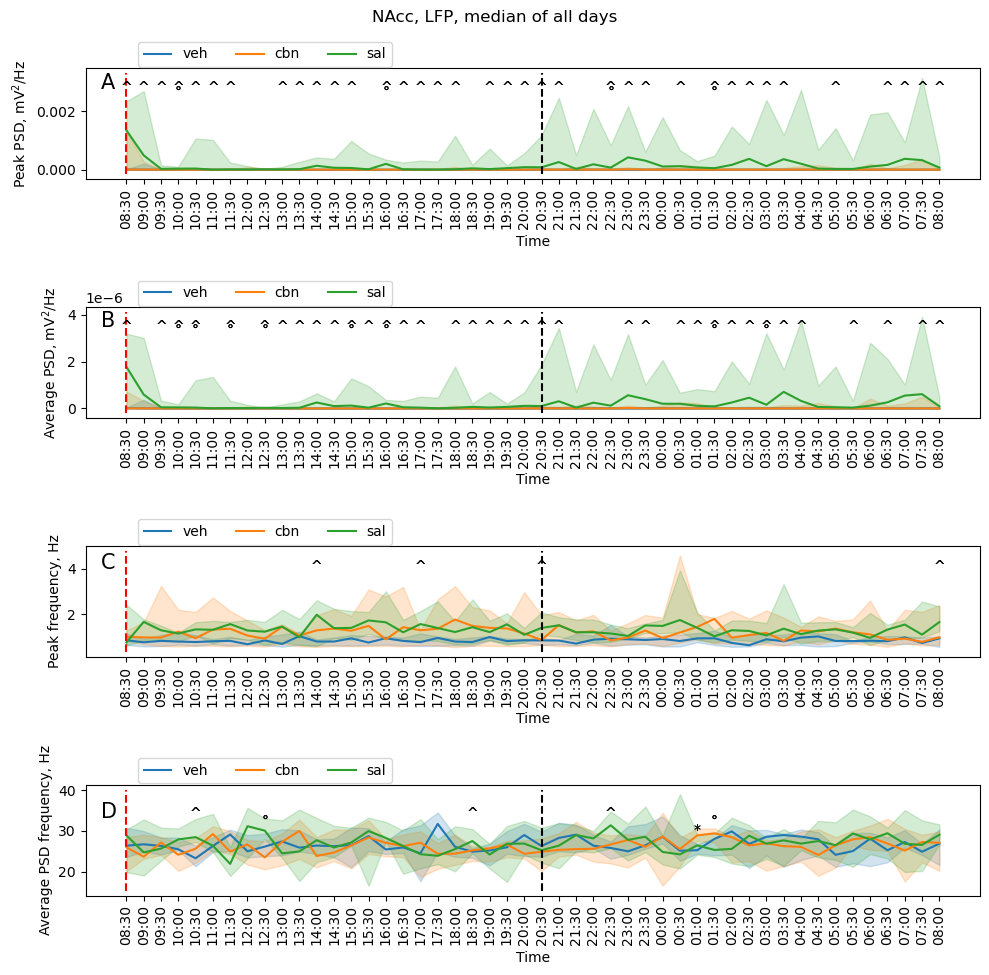

In [348]:

for ch in chs:
    fig, ax = plt.subplots(4,1,figsize = (10,10))
    for i, param in enumerate(params):
        sns.lineplot(data = time_medians.loc[(time_medians['channel'] == ch)], x = 'hour', y = param, hue = 'group', ax = ax[i], estimator = 'median', errorbar = 'ci')
        # ax[i].set(ylim = (0,time_data.loc[(time_data['channel'] == ch)&(time_data['inj'] == inj), param].quantile(0.75)))
        ax[i].tick_params(axis = 'x', labelrotation=90)
        ax[i].set(xlabel = 'Time', ylabel = param_renaming_dict[param])
        ax[i].legend(bbox_to_anchor=(0.35, 1.3), ncols = 3)
        
        xmin, xmax = ax[i].get_xlim()
        ymin, ymax = ax[i].get_ylim()
        
        ax[i].vlines(0, ymin, ymax, colors='r', linestyles='--')
        ax[i].vlines(24, ymin, ymax, colors='k', linestyles='--')
        
        cbn_veh = []
        cbn_sal = []
        veh_sal = []

        #mark signif as lines
        signif = np.array(signif_params[i], dtype=object)
        for result in signif:
            if result[1] == 'cbn' or result[2] == 'cbn':
                if result[2] == 'veh' or result[1] == 'veh':
                    cbn_veh.append(result[0])
            if result[1] == 'cbn' or result[2] == 'cbn':
                if result[2] == 'sal' or result[1] == 'sal':
                    cbn_sal.append(result[0])
            if result[1] == 'veh' or result[2] == 'veh':
                if result[2] == 'sal' or result[1] == 'sal':
                    veh_sal.append(result[0])
        
        #instead plot as text
        for x in cbn_veh:
            ax[i].text(x = x, y = ymax*0.75, s = '*', ha="center", va="center")
        for x in cbn_sal:
            ax[i].text(x = x, y = ymax*0.80, s = '°', ha="center", va="center")
        for x in veh_sal:
            ax[i].text(x = x, y = ymax*0.85, s = '^', ha="center", va="center")
        
        #add annotation
        ax[i].annotate(letters[i], xy = (-ax[i].get_xlim()[1]*0.03, ax[i].get_ylim()[1]*0.8),  size = 15)
        # for index, label in enumerate(ax[i].xaxis.get_ticklabels()):
        #     if index % 6 != 0:
        #         label.set_visible(False)
    fig.suptitle(str(ch_renaming_dict[ch])+', median of all days', y = 0.97)
    plt.tight_layout()
    plt.savefig(f'./plots/spectral_{ch}_medianbyhour.png', transparent = True, dpi = 300)
    plt.show()

In [325]:
time_medians

,id,channel,group,hour,maxpow,meanpow,maxpowf,meanpowf
96,21.0,emg,veh,08:30,1.375739e-04,1.317565e-07,0.571665,19.998822
97,21.0,emg,veh,09:00,5.410002e-04,7.687854e-07,0.954997,22.523258
98,21.0,emg,veh,09:30,4.043946e-05,5.685278e-08,0.993608,22.173259
99,21.0,emg,veh,10:00,1.065971e-06,1.641723e-09,1.355829,26.118802
100,21.0,emg,veh,10:30,3.272623e-07,1.833242e-09,0.658887,31.021563
...,...,...,...,...,...,...,...,...
10939,55.0,r_ecog,veh,06:00,4.574834e-09,8.701009e-12,0.832219,29.501013
10940,55.0,r_ecog,veh,06:30,4.812671e-09,7.455162e-12,0.706664,33.264334
10941,55.0,r_ecog,veh,07:00,5.230729e-09,7.934258e-12,0.851108,26.248801
10942,55.0,r_ecog,veh,07:30,5.079139e-09,6.941942e-12,0.839997,28.185462


In [327]:
time_medians.groupby(['hour','channel','group']).agg(['median', q1, q3]).to_excel('./results/spectral_time_medians.xlsx')

In [328]:
#overall per day
time_medians['phase'] = 'Dark'
time_medians.loc[(time_medians['hour'] >= '08:30')&(time_medians['hour'] < '20:30'), 'phase'] = 'Light'

In [329]:
byphase = time_medians.groupby(['id','group','channel','phase']).median(numeric_only=True).reset_index()

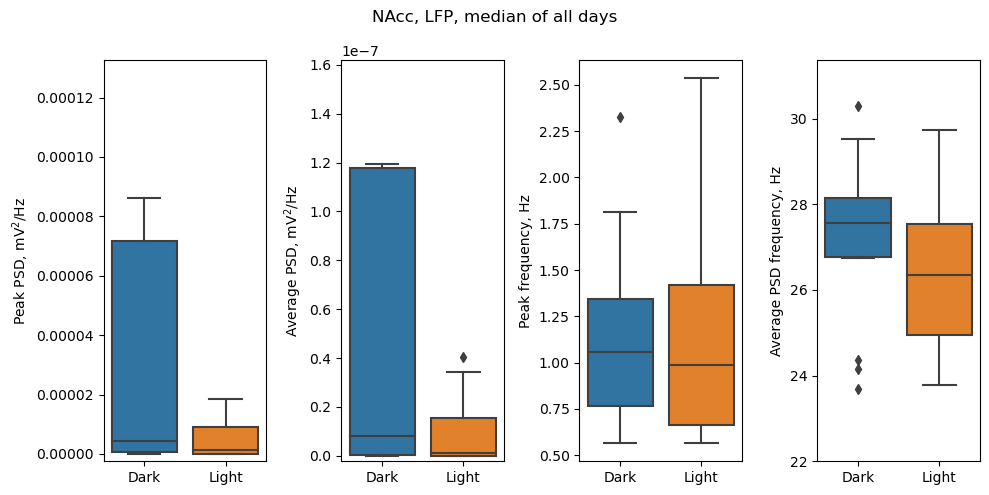

In [330]:
for ch in chs:
    fig, ax = plt.subplots(1,4, figsize = (10,5))
    for i, param in enumerate(params):
        sns.boxplot(data = byphase.loc[byphase['channel'] == ch], x = 'phase', y = param, ax = ax[i])
        ax[i].set(xlabel = None, ylabel = param_renaming_dict[param])
        if param == 'meanpowf':
            ax[i].set(ylim = (22))
        elif param == 'maxpow' or param == 'meanpow':
            ax[i].set(ylim = (0-byphase.loc[byphase['channel'] == ch, param].quantile(0.5),byphase.loc[byphase['channel'] == ch, param].quantile(0.85) ))
        # ax[i].legend(bbox_to_anchor=(1, 1.2), ncols = 2)
    fig.suptitle(ch_renaming_dict[ch]+', median of all days')
    plt.tight_layout()
    plt.savefig(f'./plots/spectral_{ch}_nogroup_lightdarkmedians.png', transparent = True, dpi = 300)
    plt.show()

In [331]:
#stats
signif_params = []
f = open('results/spectral_lightdark_median_stats.txt','w')
for i, param in enumerate(params):
    signif_times = []
    for ch in chs:
        for phase in byphase['phase'].unique():
            light_subset = byphase.loc[(byphase['phase'] == phase)&(byphase['channel']==ch)]
            cbn = light_subset[light_subset['group'] == 'cbn'][param].tolist()
            veh = light_subset[light_subset['group'] == 'veh'][param].tolist()
            sal = light_subset[light_subset['group'] == 'sal'][param].tolist()
            
            cbn = reject_outliers(cbn)
            veh = reject_outliers(veh)
            sal = reject_outliers(sal)
            
            if cbn and veh and sal:
                if (np.sum(cbn) != np.sum(veh)) and (np.sum(cbn)!=np.sum(sal)):
                    stat, p = stats.kruskal(cbn, veh, sal)
                    if p < 0.05:
                        print(f'n cbn: {len(cbn)}, n veh: {len(veh)}, n sal: {len(sal)}')
                        print(f'{phase} phase, {ch} channel, param {param} significant, p = {p}, stat = {stat}')
                        f.write(f'n cbn: {len(cbn)}, n veh: {len(veh)}, n sal: {len(sal)}\n')
                        f.write(f'{phase} phase, {ch} channel, param {param} significant, p = {p}, stat = {stat}')
                        dunn_res = posthoc_dunn([cbn, veh, sal], p_adjust = 'bonferroni')
                        dunn_res.columns = ['cbn','veh','sal']
                        dunn_res.index = ['cbn','veh','sal']
                        if (dunn_res <= 0.05).any().any():
    #                         #check which groups were different
                            print(dunn_res)                       
                            for p_col in dunn_res.columns:
                                for p_row in dunn_res.index:
                                    p = dunn_res.loc[p_row, p_col]
                                    if p < 0.05:
                                        signif_times.append([phase, p_row, p_col])
                            f.write(dunn_res.to_string())
                        else:
                            print('posthoc ns')
                            f.write('posthoc ns')
                        f.write('\n')
        signif_params.append(signif_times)
f.close()

found 1 outliers
found 1 outliers
n cbn: 6, n veh: 6, n sal: 5
Dark phase, lfp channel, param maxpow significant, p = 0.013218422336178046, stat = 8.65228758169934
          cbn       veh       sal
cbn  1.000000  1.000000  0.095253
veh  1.000000  1.000000  0.012866
sal  0.095253  0.012866  1.000000
found 1 outliers
n cbn: 7, n veh: 6, n sal: 5
Light phase, lfp channel, param maxpow significant, p = 0.01641284705339707, stat = 8.219381787802831
          cbn       veh       sal
cbn  1.000000  0.503845  0.294160
veh  0.503845  1.000000  0.012448
sal  0.294160  0.012448  1.000000
found 1 outliers
found 1 outliers
n cbn: 6, n veh: 6, n sal: 5
Dark phase, lfp channel, param meanpow significant, p = 0.019861854454477787, stat = 7.837908496732027
          cbn       veh       sal
cbn  1.000000  1.000000  0.097885
veh  1.000000  1.000000  0.021976
sal  0.097885  0.021976  1.000000
found 1 outliers
n cbn: 7, n veh: 6, n sal: 5
Light phase, lfp channel, param meanpow significant, p = 0.015546655

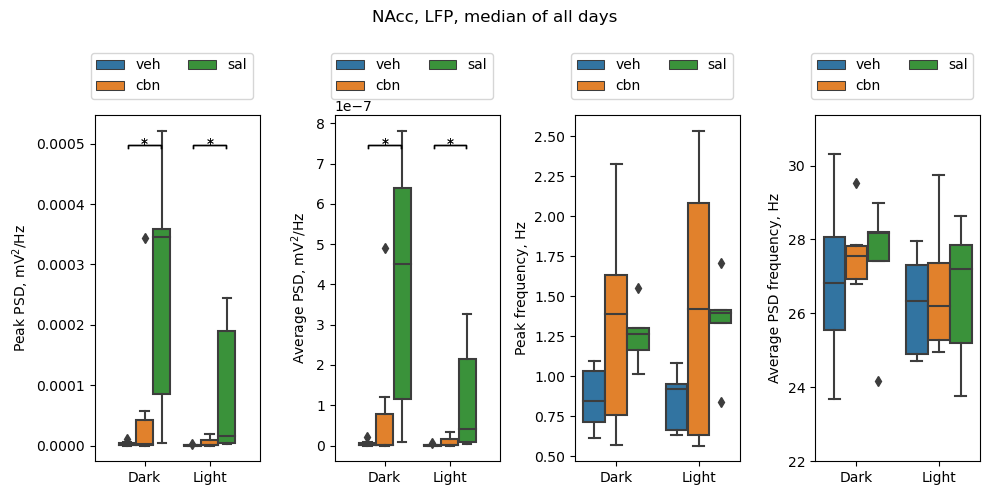

In [332]:
for ch in chs:
    fig, ax = plt.subplots(1,4, figsize = (10,5))
    for i, param in enumerate(params):
        sns.boxplot(data = byphase.loc[byphase['channel'] == ch], x = 'phase', y = param, hue = 'group', ax = ax[i])
        ax[i].set(xlabel = None, ylabel = param_renaming_dict[param])
        ax[i].legend(bbox_to_anchor=(1, 1.2), ncols = 2)
        
        ymin, ymax = ax[i].get_ylim()
        xmin, xmax = ax[i].get_xlim()
        
        if param == 'meanpowf':
            ax[i].set(ylim = (22))
        
        cbn_veh = []
        cbn_sal = []
        veh_sal = []

        #mark signif as lines
        signif = np.array(signif_params[i], dtype=object)
        for result in signif:
            if result[1] == 'cbn' or result[2] == 'cbn':
                if result[2] == 'veh' or result[1] == 'veh':
                    cbn_veh.append(result[0])
            if result[1] == 'cbn' or result[2] == 'cbn':
                if result[2] == 'sal' or result[1] == 'sal':
                    cbn_sal.append(result[0])
            if result[1] == 'veh' or result[2] == 'veh':
                if result[2] == 'sal' or result[1] == 'sal':
                    veh_sal.append(result[0])
    
        # #instead plot as text
        y = ymax*0.9
        h = y*0.01
        offset = 0.25
        for x in cbn_veh:
            if x == 'Light':
                xmin, xmax= 0-offset, 0, 
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'Dark':
                xmin, xmax = 1-offset, 1
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
        for x in cbn_sal:
            if x == 'Light':
                xmin, xmax = 0, 0+offset
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'Dark':
                xmin, xmax = 1, 1+offset
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
        for x in veh_sal:
            if x == 'Light':
                xmin, xmax = 0-offset, 0+offset
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'Dark':
                xmin, xmax = 1-offset, 1+offset
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
        
        
    fig.suptitle(ch_renaming_dict[ch]+', median of all days')
    plt.tight_layout()
    plt.savefig(f'./plots/spectral_{ch}_lightdarkmedians.png', transparent = True, dpi = 300)
    plt.show()

In [333]:
byphase.groupby(['phase','channel','group']).agg(['median', q1, q3]).to_excel('./results/spectral_lightdark_medians.xlsx')

In [334]:
#NEXT - continue with states
#same issue - duplicated indices
state_data[['maxpow', 'meanpow', 'maxpowf', 'meanpowf']] = state_data[['maxpow', 'meanpow', 'maxpowf', 'meanpowf']].astype(float)
state_data = state_data.dropna()

In [335]:
state_data['inj'].unique()#.drop(['state_id','time'],axis = 1).groupby(['id','sleep','channel','group','inj']).median()

['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'single']
Categories (11, object): ['none' < 'single' < 'cont1' < 'cont2' ... 'cont6' < 'cont7' < 'sp_sp' < 'sp_w']

In [336]:
#grouping
grouped = []
for id in state_data['id'].unique():
    for ch in state_data['channel'].unique():
        id_subset = state_data.loc[(state_data['id']==id)&(state_data['channel']==ch)]
        grouped.append(id_subset.groupby(['id','sleep','channel','group','inj']).median(numeric_only = True).reset_index().dropna())
state_data = pd.concat(grouped)

In [337]:
#again no point
# for ch in chs:
#     fig, ax = plt.subplots(len(state_data['inj'].unique()), 4, figsize = (10,20))
#     for i_row, inj in enumerate(state_data['inj'].unique()):
#         for i_col, param in enumerate(params):
#             sns.boxplot(data = state_data.loc[state_data['inj'] == inj], x = 'sleep', hue = 'group', y = param, ax = ax[i_row][i_col])

In [338]:
#check medians
state_medians = state_data.groupby(['id','sleep','channel','group']).median(numeric_only=True).reset_index()
n_cbn = len(state_medians[state_medians['group']=='cbn']['id'].unique())
n_veh = len(state_medians[state_medians['group']=='veh']['id'].unique())
n_sal = len(state_medians[state_medians['group']=='sal']['id'].unique())
print(f'cbn group n = {n_cbn}')
print(f'veh group n = {n_veh}')
print(f'sal group n = {n_sal}')

cbn group n = 7
veh group n = 7
sal group n = 5


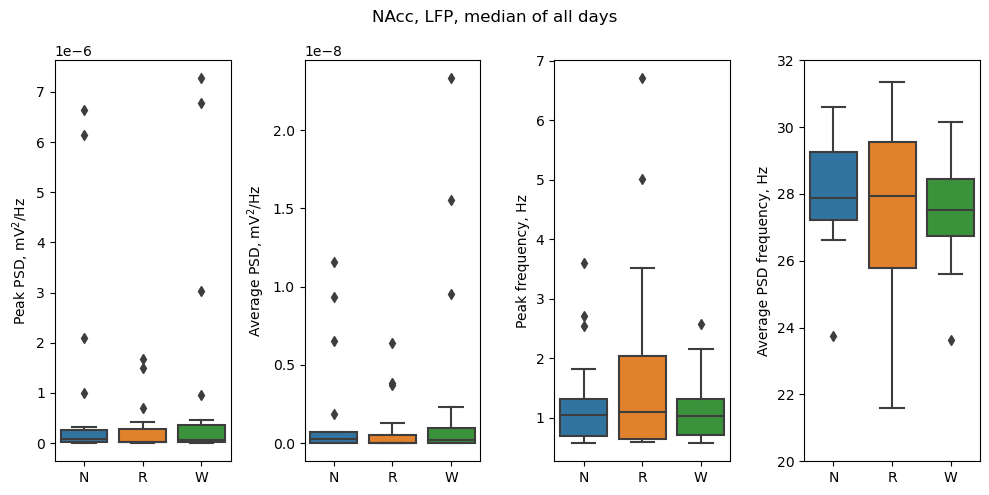

In [339]:
for ch in chs:
    fig, ax = plt.subplots(1,4,figsize = (10,5))
    for i, param in enumerate(params):
        sns.boxplot(data = state_medians.loc[state_medians['channel']==ch], x = 'sleep', y = param, ax =ax[i])
        ax[i].set(xlabel = None, ylabel = param_renaming_dict[param])
        # ax[i].legend(bbox_to_anchor=(1, 1.2), ncols = 2)
        if param == 'meanpowf':
            ax[i].set(ylim = (20,32))
    fig.suptitle(ch_renaming_dict[ch]+', median of all days')
    plt.tight_layout()
    plt.savefig(f'./plots/spectral_{ch}_nogroups_bystate_medians.png', transparent = True, dpi = 300)
    plt.show()

In [340]:
#stats
signif_params = []
f = open('results/spectral_sleepstate_median_stats.txt','w')
for i, param in enumerate(params):
    signif_times = []
    for ch in chs:
        for phase in state_medians['sleep'].unique():
            light_subset = state_medians.loc[(state_medians['sleep'] == phase)&(state_medians['channel']==ch)]
            cbn = light_subset[light_subset['group'] == 'cbn'][param].tolist()
            veh = light_subset[light_subset['group'] == 'veh'][param].tolist()
            sal = light_subset[light_subset['group'] == 'sal'][param].tolist()
            
            cbn = reject_outliers(cbn)
            veh = reject_outliers(veh)
            sal = reject_outliers(sal)
            
            if cbn and veh and sal:
                if (np.sum(cbn) != np.sum(veh)) and (np.sum(cbn)!=np.sum(sal)):
                    stat, p = stats.kruskal(cbn, veh, sal)
                    if p < 0.05:
                        print(f'n cbn: {len(cbn)}, n veh: {len(veh)}, n sal: {len(sal)}')
                        print(f'{phase} phase, {ch} channel, param {param} significant, p = {p}, stat = {stat}')
                        f.write(f'n cbn: {len(cbn)}, n veh: {len(veh)}, n sal: {len(sal)}\n')
                        f.write(f'{phase} phase, {ch} channel, param {param} significant, p = {p}, stat = {stat}')
                        dunn_res = posthoc_dunn([cbn, veh, sal], p_adjust = 'bonferroni')
                        dunn_res.columns = ['cbn','veh','sal']
                        dunn_res.index = ['cbn','veh','sal']
                        if (dunn_res <= 0.05).any().any():
    #                         #check which groups were different
                            print(dunn_res)                       
                            for p_col in dunn_res.columns:
                                for p_row in dunn_res.index:
                                    p = dunn_res.loc[p_row, p_col]
                                    if p < 0.05:
                                        signif_times.append([phase, p_row, p_col])
                            f.write(dunn_res.to_string())
                        else:
                            print('posthoc ns')
                            f.write('posthoc ns')
                        f.write('\n')
        signif_params.append(signif_times)
f.close()

found 1 outliers
found 1 outliers
n cbn: 6, n veh: 6, n sal: 5
N phase, lfp channel, param maxpow significant, p = 0.028659004795419555, stat = 7.104575163398685
          cbn       veh       sal
cbn  1.000000  1.000000  0.100578
veh  1.000000  1.000000  0.036501
sal  0.100578  0.036501  1.000000
found 1 outliers
found 2 outliers
n cbn: 6, n veh: 5, n sal: 5
W phase, lfp channel, param maxpow significant, p = 0.04848646518988427, stat = 6.052941176470597
posthoc ns
found 1 outliers
found 1 outliers
n cbn: 6, n veh: 6, n sal: 5
N phase, lfp channel, param meanpow significant, p = 0.016725016721081877, stat = 8.181699346405225
         cbn       veh       sal
cbn  1.00000  1.000000  0.054010
veh  1.00000  1.000000  0.025013
sal  0.05401  0.025013  1.000000
found 1 outliers
found 1 outliers
found 1 outliers
n cbn: 6, n veh: 6, n sal: 5
W phase, lfp channel, param meanpow significant, p = 0.016725016721081877, stat = 8.181699346405225
         cbn       veh       sal
cbn  1.00000  1.000000

In [341]:
signif_params

[[['N', 'sal', 'veh'], ['N', 'veh', 'sal']],
 [['N', 'sal', 'veh'],
  ['N', 'veh', 'sal'],
  ['W', 'sal', 'veh'],
  ['W', 'veh', 'sal']],
 [],
 []]

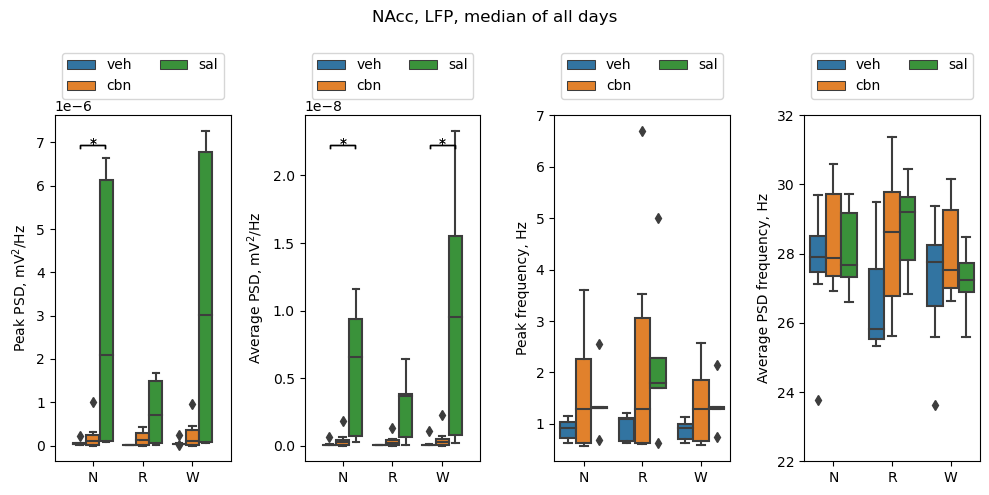

In [342]:
for ch in chs:
    fig, ax = plt.subplots(1,4,figsize = (10,5))
    for i, param in enumerate(params):
        sns.boxplot(data = state_medians.loc[state_medians['channel']==ch], x = 'sleep', y = param, hue = 'group', ax =ax[i])
        ax[i].set(xlabel = None, ylabel = param_renaming_dict[param])
        ax[i].legend(bbox_to_anchor=(1, 1.2), ncols = 2)
        if param == 'meanpowf':
            ax[i].set(ylim = (20,32))
        
        ymin, ymax = ax[i].get_ylim()
        xmin, xmax = ax[i].get_xlim()
        
        if param == 'meanpowf':
            ax[i].set(ylim = (22))
        
        cbn_veh = []
        cbn_sal = []
        veh_sal = []

        #mark signif as lines
        signif = np.array(signif_params[i], dtype=object)
        for result in signif:
            if result[1] == 'cbn' or result[2] == 'cbn':
                if result[2] == 'veh' or result[1] == 'veh':
                    cbn_veh.append(result[0])
            if result[1] == 'cbn' or result[2] == 'cbn':
                if result[2] == 'sal' or result[1] == 'sal':
                    cbn_sal.append(result[0])
            if result[1] == 'veh' or result[2] == 'veh':
                if result[2] == 'sal' or result[1] == 'sal':
                    veh_sal.append(result[0])
    
        # #instead plot as text
        y = ymax*0.9
        h = y*0.01
        offset = 0.25
        for x in cbn_veh:
            if x == 'N':
                xmin, xmax= 0-offset, 0, 
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'W':
                xmin, xmax = 2-offset, 2
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'R':
                xmin, xmax = 1-offset, 1
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
        for x in cbn_sal:
            if x == 'N':
                xmin, xmax= 0+offset, 0, 
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'W':
                xmin, xmax = 2+offset, 2
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'R':
                xmin, xmax = 1+offset, 1
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
        for x in veh_sal:
            if x == 'N':
                xmin, xmax= 0-offset, 0+offset, 
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'W':
                xmin, xmax = 2-offset, 2+offset
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
            elif x == 'R':
                xmin, xmax = 1-offset, 1+offset
                ax[i].plot([xmin, xmin, xmax, xmax], [y, y+h, y+h, y], linewidth=1, c='k')
                ax[i].text((xmin+xmax)*.5, y-h, "*", ha='center', va='bottom', color='k')
         
            
    fig.suptitle(ch_renaming_dict[ch]+', median of all days')
    plt.tight_layout()
    plt.savefig(f'./plots/spectral_{ch}_bystate_medians.png', transparent = True, dpi = 300)
    plt.show()

In [343]:
#save to excel
state_medians.groupby(['sleep','channel','group']).agg(['median', q1, q3]).to_excel('./results/spectral_bystate_medians.xlsx')